# MNIST GPU Deep Learning Benchmark with H2O Deep Water
In reference to [Szilard's Benchmark-DL](https://github.com/szilard/benchm-dl)

![MNIST](images/mnist.png)

In [1]:
import sys, os
import os.path
import h2o
from h2o.estimators.deepwater import H2ODeepWaterEstimator
PATH = os.path.expanduser("~/h2o-3/")
#h2o.shutdown(prompt=False)
h2o.init(nthreads=-1)
if not H2ODeepWaterEstimator.available(): exit

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_101"; Java(TM) SE Runtime Environment (build 1.8.0_101-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.101-b13, mixed mode)
  Starting server from /home/arno/h2o-3/build/h2o.jar
  Ice root: /tmp/tmpl_LfUm
  JVM stdout: /tmp/tmpl_LfUm/h2o_arno_started_from_python.out
  JVM stderr: /tmp/tmpl_LfUm/h2o_arno_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster version:,3.11.0.99999
H2O cluster version age:,49 minutes
H2O cluster name:,H2O_from_python_arno_q7s875
H2O cluster total nodes:,1
H2O cluster free memory:,13.96 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,40
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


### Hardware check

In [2]:
!nvidia-smi

Mon Oct 24 14:43:12 2016       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 367.44                 Driver Version: 367.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:02:00.0      On |                  N/A |
| 33%   43C    P8    11W / 180W |   1520MiB /  8097MiB |     11%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:81:00.0      On |                  N/A |
| 39%   55C    P8    12W / 180W |   3273MiB /  8113MiB |     16%      Default |
+-------------------------------+----------------------+----------------------+
        

### Data preparation

In [3]:
train = h2o.import_file(PATH + "bigdata/laptop/mnist/train.csv.gz")
predictors  = list(range(0,784))
resp        = 784

train[predictors] = train[predictors]/255.0
train[resp] = train[resp].asfactor()
nclasses    = train[resp].nlevels()[0]

Parse progress: |█████████████████████████████████████████████████████████| 100%


### Define the model architecture

In [4]:
def cnn(num_classes):
    import mxnet as mx
    data    = mx.symbol.Variable('data')

    conv1   = mx.symbol.Convolution(data=data, kernel=(4,4), num_filter=32)
    relu1   = mx.symbol.Activation(data=conv1, act_type="relu")
    pool1   = mx.symbol.Pooling(data=relu1, pool_type="max", kernel=(2,2), stride=(2,2))

    conv2   = mx.symbol.Convolution(data=pool1, kernel=(3,3), num_filter=16)
    relu2   = mx.symbol.Activation(data=conv2, act_type="relu")
    pool2   = mx.symbol.Pooling(data=relu2, pool_type="max", kernel=(2,2), stride=(2,2))
    drop    = mx.symbol.Dropout(data=pool2, p=0.2)

    flatten = mx.symbol.Flatten(data=drop)
    fc1     = mx.symbol.FullyConnected(data=flatten, num_hidden=128)
    relu3   = mx.symbol.Activation(data=fc1, act_type="relu")

    fc2     = mx.symbol.FullyConnected(data=relu3, num_hidden=64)
    relu4   = mx.symbol.Activation(data=fc2, act_type="relu")

    fc3     = mx.symbol.FullyConnected(data=relu4, num_hidden=num_classes)
    net     = mx.symbol.SoftmaxOutput(data=fc3, name='softmax')
    return net
cnn(nclasses).save("/tmp/cnn.json")

### Train the model

In [5]:
model = H2ODeepWaterEstimator(epochs=10,
                              learning_rate=0.05,
                              learning_rate_annealing=1e-5,
                              momentum_start=0.9,
                              momentum_stable=0.9,
                              mini_batch_size=128,
                              train_samples_per_iteration=0,
                              standardize=False,
                              ignore_const_cols=False,
                              network_definition_file="/tmp/cnn.json",
                              image_shape=[28,28],
                              channels=1,
                              device_id=[0])

model.train(x=predictors,y=resp, training_frame=train)

deepwater Model Build progress: |█████████████████████████████████████████| 100%


### Inspect the model

In [6]:
model.show()

Model Details
H2ODeepWaterEstimator :  Deep Water
Model Key:  DeepWater_model_python_1477345387898_1
Status of Deep Learning Model: user, 261.3 KB, predicting C785, 10-class classification, 600,320 training samples, mini-batch size 128



,input_neurons,rate,momentum
,784,0.0071396,0.9




ModelMetricsMultinomial: deepwater
** Reported on train data. **

MSE: 0.00416394936921
RMSE: 0.0645286709085
LogLoss: 0.0165712667225
Mean Per-Class Error: 0.00435341611851
Confusion Matrix: vertical: actual; across: predicted



0,1,2,3,4,5,6,7,8,9,Error,Rate
1009.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0019782,"2 / 1,011"
1.0,1082.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0036832,"4 / 1,086"
1.0,0.0,1026.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0019455,"2 / 1,028"
0.0,0.0,0.0,998.0,0.0,2.0,0.0,1.0,2.0,0.0,0.0049850,"5 / 1,003"
0.0,0.0,0.0,0.0,943.0,0.0,0.0,0.0,0.0,6.0,0.0063224,6 / 949
0.0,0.0,1.0,1.0,0.0,860.0,0.0,0.0,2.0,0.0,0.0046296,4 / 864
4.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,0.0,0.0,0.0038911,"4 / 1,028"
0.0,1.0,5.0,0.0,0.0,0.0,0.0,1017.0,0.0,1.0,0.0068359,"7 / 1,024"
0.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0,952.0,1.0,0.0062630,6 / 958
0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,997.0,0.003,"3 / 1,000"


Top-10 Hit Ratios: 


k,hit_ratio
1,0.9956788
2,0.9988946
3,0.999598
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0
10,1.0


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error
,2016-10-24 14:43:22,0.000 sec,None,0.0,0,0.0,nan,nan,nan
,2016-10-24 14:43:49,31.020 sec,23103 obs/sec,10.0053333,10,600320.0,0.0645287,0.0165713,0.0043212


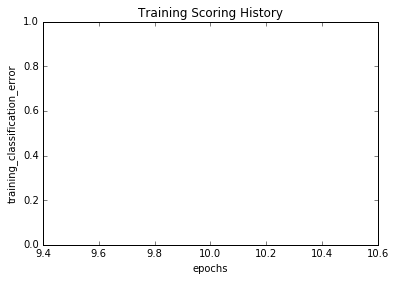

In [7]:
model.plot()

### Let's evaluate the test set performance

In [8]:
test = h2o.import_file(PATH + "bigdata/laptop/mnist/test.csv.gz")
test[predictors] = test[predictors]/255.0
test[resp] = test[resp].asfactor()

print(model.model_performance(test))

Parse progress: |█████████████████████████████████████████████████████████| 100%

ModelMetricsMultinomial: deepwater
** Reported on test data. **

MSE: 0.00674407577248
RMSE: 0.082122322011
LogLoss: 0.0251662757639
Mean Per-Class Error: 0.00816183147887
Confusion Matrix: vertical: actual; across: predicted



0,1,2,3,4,5,6,7,8,9,Error,Rate
979.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0010204,1 / 980
0.0,1131.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0035242,"4 / 1,135"
1.0,0.0,1026.0,0.0,1.0,0.0,0.0,3.0,1.0,0.0,0.0058140,"6 / 1,032"
0.0,0.0,2.0,1005.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0049505,"5 / 1,010"
0.0,0.0,2.0,0.0,968.0,0.0,1.0,0.0,1.0,10.0,0.0142566,14 / 982
0.0,0.0,0.0,4.0,0.0,887.0,1.0,0.0,0.0,0.0,0.0056054,5 / 892
6.0,2.0,1.0,0.0,1.0,3.0,943.0,0.0,2.0,0.0,0.0156576,15 / 958
0.0,3.0,4.0,0.0,0.0,0.0,0.0,1018.0,1.0,2.0,0.0097276,"10 / 1,028"
1.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,967.0,1.0,0.0071869,7 / 974
0.0,3.0,0.0,0.0,4.0,0.0,0.0,5.0,2.0,995.0,0.0138751,"14 / 1,009"


Top-10 Hit Ratios: 


k,hit_ratio
1,0.9919
2,0.9987
3,0.9995000
4,0.9998
5,0.9998
6,1.0
7,1.0
8,1.0
9,1.0
10,1.0


In [9]:
h2o.download_all_logs("/tmp/")

Writing H2O logs to /tmp/h2ologs_20161024_024355.zip


u'/tmp/h2ologs_20161024_024355.zip'